# Introduction
Cryptocurrency is the future of online currency and traditional trading. Due to the recent rise of technology and market changes, everyone wants to buy cryptocurrency. I’ll be building a basic Deep Neural Network model to predict Ethereum closing price for future dates based on historical data.

In [1]:
# Loading all the libraries and dependencies required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM

%matplotlib inline

Using TensorFlow backend.


# Dataset 
 - Source -> https://www.cryptodatadownload.com/data/binance/
 - We now have the historical data of ethereum from 18 December,2017 to 16 April, 2021.
 - This data is sorted by time and recorded at equal intervals (1-day). Such a sequence of data is called Time Series.
 - When we do Time Series forecasting, the value of current time step affects the next one.
 - There are many methods that you can use for this purpose. But we’ll build a Deep Neural Network  to predict future Ethereum price.
 - Reason behind choosing ethereum:
    + Very secure
    + Much more scalable than Bitcoin
    + Smart contracts, dApps
    + Revolutionary blockchain technology

#### Making dataset ready  

In [2]:
# Reading data from csv and storing it into a dataframe
df = pd.read_csv('Binance_ETHUSDT_d.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
0,1618531200000,2021-04-16 00:00:00,ETH/USDT,2514.04,2548.29,2300.00,2422.67,999163.75205,2.418567e+09,1679215
1,1618444800000,2021-04-15 00:00:00,ETH/USDT,2432.59,2543.47,2400.00,2514.04,681950.96645,1.680063e+09,1462768
2,1618358400000,2021-04-14 00:00:00,ETH/USDT,2299.19,2447.29,2281.33,2432.60,972931.60866,2.294753e+09,1554097
3,1618272000000,2021-04-13 00:00:00,ETH/USDT,2137.86,2318.00,2135.53,2299.19,782608.62090,1.745822e+09,1288668
4,1618185600000,2021-04-12 00:00:00,ETH/USDT,2151.42,2203.46,2102.00,2137.69,579093.35694,1.244983e+09,914567


In [3]:
# Since, all the timestamps are of midnight, removing time from date column
def return_date(x):
    return x.split()[0]
df['date'] = df['date'].apply(return_date)
df.head()

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
0,1618531200000,2021-04-16,ETH/USDT,2514.04,2548.29,2300.00,2422.67,999163.75205,2.418567e+09,1679215
1,1618444800000,2021-04-15,ETH/USDT,2432.59,2543.47,2400.00,2514.04,681950.96645,1.680063e+09,1462768
2,1618358400000,2021-04-14,ETH/USDT,2299.19,2447.29,2281.33,2432.60,972931.60866,2.294753e+09,1554097
3,1618272000000,2021-04-13,ETH/USDT,2137.86,2318.00,2135.53,2299.19,782608.62090,1.745822e+09,1288668
4,1618185600000,2021-04-12,ETH/USDT,2151.42,2203.46,2102.00,2137.69,579093.35694,1.244983e+09,914567


In [4]:
# Sorting values to get old ones first and we predict the latest ones
df.sort_values("date", axis = 0, ascending = True, inplace = True)
df.head()

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
1215,1513555200000,2017-12-18,ETH/USDT,707.62,798.88,638.00,784.00,45673.70777,3.279995e+07,40460
1214,1513641600000,2017-12-19,ETH/USDT,784.00,864.90,729.01,798.00,69423.62125,5.512397e+07,57020
1213,1513728000000,2017-12-20,ETH/USDT,798.00,828.00,661.00,790.21,72526.28416,5.560451e+07,58344
1212,1513814400000,2017-12-21,ETH/USDT,794.62,845.99,705.98,782.41,78222.53998,6.205252e+07,57627
1211,1513900800000,2017-12-22,ETH/USDT,784.00,796.00,504.99,635.97,154630.49482,9.866181e+07,113138


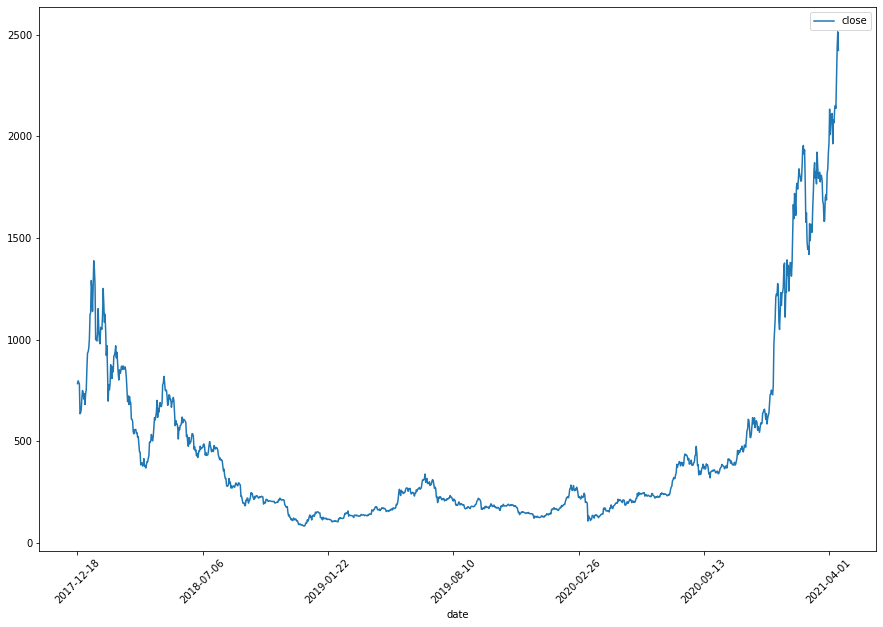

In [5]:
# Here's a plot of Ethereum prices from December, 2017 to April, 2021
df.plot('date','close', figsize=(15,10))
plt.xticks(rotation=45);

 - Start-date -> 18/12/2017
 -  End-date -> 16/04/2021
 - We can observe that there is a clear dip in prices between December 2017 and July 2018. Then, prices remain constant with spikes till July 2020. Then, prices keep on increasing till April 2021 with fluctuations happening in the months of January and February. 

In [6]:
# We have almost 3 years of data and 10 columns
df.shape

(1216, 10)

In [7]:
# Setting date as index for better modelling
df = df.set_index('date')
df.head()

,unix,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
date,,,,,,,,,
2017-12-18,1513555200000,ETH/USDT,707.62,798.88,638.00,784.00,45673.70777,3.279995e+07,40460
2017-12-19,1513641600000,ETH/USDT,784.00,864.90,729.01,798.00,69423.62125,5.512397e+07,57020
2017-12-20,1513728000000,ETH/USDT,798.00,828.00,661.00,790.21,72526.28416,5.560451e+07,58344
2017-12-21,1513814400000,ETH/USDT,794.62,845.99,705.98,782.41,78222.53998,6.205252e+07,57627
2017-12-22,1513900800000,ETH/USDT,784.00,796.00,504.99,635.97,154630.49482,9.866181e+07,113138


In [8]:
# Dropping columns which are not required in analysis
df.drop(['unix', 'symbol', 'tradecount'], axis = 1, inplace = True)

In [9]:
df.head()

,open,high,low,close,Volume ETH,Volume USDT
date,,,,,,
2017-12-18,707.62,798.88,638.00,784.00,45673.70777,3.279995e+07
2017-12-19,784.00,864.90,729.01,798.00,69423.62125,5.512397e+07
2017-12-20,798.00,828.00,661.00,790.21,72526.28416,5.560451e+07
2017-12-21,794.62,845.99,705.98,782.41,78222.53998,6.205252e+07
2017-12-22,784.00,796.00,504.99,635.97,154630.49482,9.866181e+07


- And here's our final dataset! Columns of dataset:
   - close -> It is the market close price for currency for that particular day.
   - high -> It is highest price of currency for the day.
   - low -> It is the lowest price for currency for that day.
   - open -> It is market open price for currency for that day.
   - Volume ETH -> The volume of currency that is being in trade for that day.
   - Volume USDT -> The volume of currency that is being in trade for that day in US dollars

# Data Processing
- Our model will use previous data to predict the next day’s closing price of a specific coin. LSTM (Why LSTM? Explained later) requires the input to be a 3D tensor with shape (batch_size, window_size, input_dim). I must decide how many previous days it will have access to. Again, it’s random, but I’ll go for 10 days. I will re-organize the data in a way that a sequence of the values in previous 10 days is used to predict the value at a time t. We build little data frames consisting of 10 consecutive days of data called windows, so the first window will consist of the 0-9th rows of the training set, the second will be the rows 1-10, etc. Picking a small window size means we can feed more windows into our model; the downside is that the model may not have sufficient information to detect complex long term behaviours.

- Here, I only use "close" price to make the prediction so the input_dim is 1. The target variable is "close" price of ethereum which can be effected by many other factors. If you also use a second variable to make the prediction, than the input_dim will be 2.

In [10]:
data = df.iloc[:, 3]
windows = []
target = []
length = 10
for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    windows.append(x)
    target.append(y)

In [11]:
windows = np.array(windows)
target = np.array(target)
target = target.reshape(-1,1)
windows.shape, target.shape

((1206, 10), (1206, 1))

- Also, I am going to squish our price data in a specific range. This will help our optimization algorithm converge faster. Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. For this, I have used MinMax Scaler from sklearn.

- MinMaxScaler transform features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range. 

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
windows_scaled = sc.fit_transform(windows)
target_scaled = sc.fit_transform(target)

In [13]:
windows_scaled = windows_scaled.reshape((len(windows_scaled), length, 1))
windows_scaled.shape

(1206, 10, 1)

- Next, I split the data into two sets — training set and test set with 80% and 20% data respectively.

In [14]:
num_train = int(0.80 * windows_scaled.shape[0])

X_train = windows_scaled[:num_train,:,:]
X_test = windows_scaled[num_train:,:,:]
y_train = target_scaled[:num_train,:]
y_test = target_scaled[num_train:,:]

- Here's a plot of Ethereum prices from December, 2017 to April, 2021 (Divided in training and testing set)

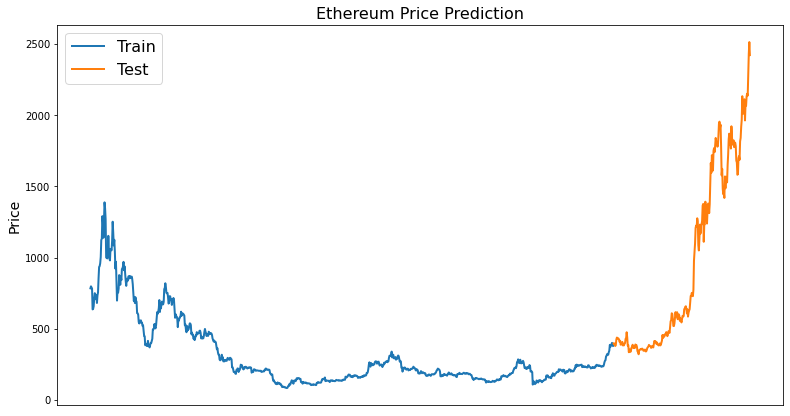

In [15]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df.iloc[:num_train, 3], label="Train", linewidth=2)
ax.plot(df.iloc[num_train:, 3], label="Test", linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('Ethereum Price Prediction', fontsize=16)
ax.get_xaxis().set_visible(False)
ax.legend(loc='best', fontsize=16)

# Building the Model

- I will be using a special class of Neural Network models known as Recurrent Neural Networks (RNNs) just for this purpose. RNNs allow using the output from the model as a new input for the same model. The process can be repeated indefinitely. One serious limitation of RNNs is the inability of capturing long-term dependencies in a sequence. One way to handle the situation is by using an Long short-term memory (LSTM) variant of RNN. The default LSTM behavior is remembering information for prolonged periods of time.

- RNN LSTM works by using special gates to allow each LSTM layer to take information from both previous layers and the current layer. The data goes through multiple gates (like forget gate, input gate, etc.) and various activation functions (like the tanh function, relu function) and is passed through the LSTM cells. The main advantage of this is that it allows each LSTM cell to remember patterns for a certain amount of time. The thing to be noted is that LSTM can remember important information and at the same time forget irrelevant information. 

- Now let’s build the model. Sequential model is used for stacking all the layers (input, hidden and output). The neural network comprises of a LSTM layer followed by Dropout layer and a Dense layer with linear activation function. I complied the model using Adam as the optimizer and Mean Squared Error as the loss function.

In [16]:
def build_lstm_model(input_data, output_size, neurons, activ_func, dropout, loss, optimizer):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

- I used Mean Squared Error (MSE) as the evaluation metric. MSE is used to check how close estimates or forecasts are to actual values. Lower the MSE, the closer is forecast to actual.

- Added 20 %dropout layer in order to reduce overfitting to the training data.

- The model uses the AdamOptimizer as its optimization function. The AdamOptimizer is an algorithm for first-order gradient-based optimization of functions and based on adaptive estimates of lower order moments.

- A dense layer with a linear activation function is used in this model to determine the output of each neuron in the model.

In [17]:
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = 'linear'

# Training the Model

- The model will be fitted to the training data (which was X_train and y_train), with a batch_size of 32. Additionally, 20 epochs will be performed to give the model time to adjust its weights and biases to fit the training data. I also added validation split to see how well model generalizes on unseen data after each epoch.

In [18]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, activ_func=activ_func,
                             dropout=dropout, loss=loss, optimizer=optimizer)
out = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Train on 867 samples, validate on 97 samples
Epoch 1/20
867/867 [==============================] - 0s 528us/step - loss: 0.0035 - val_loss: 9.5474e-05
Epoch 2/20
867/867 [==============================] - 0s 166us/step - loss: 6.1195e-04 - val_loss: 1.0017e-04
Epoch 3/20
867/867 [==============================] - 0s 181us/step - loss: 5.5783e-04 - val_loss: 1.3113e-04
Epoch 4/20
867/867 [==============================] - 0s 186us/step - loss: 5.8590e-04 - val_loss: 3.4815e-04
Epoch 5/20
867/867 [==============================] - 0s 165us/step - loss: 5.9038e-04 - val_loss: 8.6983e-05
Epoch 6/20
867/867 [==============================] - 0s 177us/step - loss: 4.8506e-04 - val_loss: 1.0044e-04
Epoch 7/20
867/867 [==============================] - 0s 185us/step - loss: 5.0948e-04 - val_loss: 4.3166e-04
Epoch 8/20
867/867 [==============================] - 0s 183us/step - loss: 6.2589e-04 - val_loss: 5.8379e-05
Epoch 9/20
867/867 [==============================] - 0s 194us/step - loss: 4.8

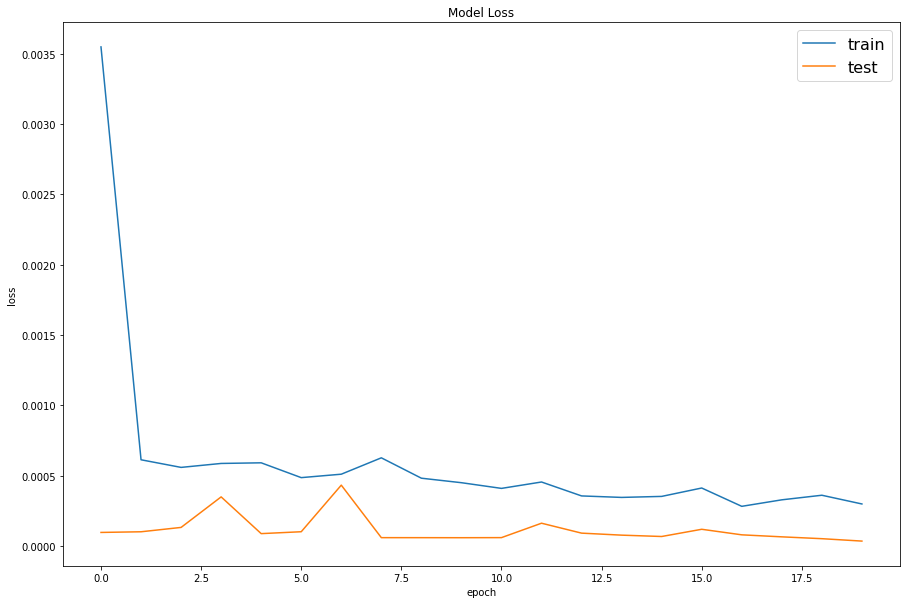

In [19]:
# Let's visualize how loss changes as number of epochs increases
plt.figure(figsize=(15,10))
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best', fontsize=16)
plt.show()

# Testing the Model

- The model will be given the x values of the testing data and will make predictions of the normalized prices. This will be stored as pred.

In [20]:
pred = model.predict(X_test)
pred_transformed = sc.inverse_transform(pred)
y_test_transformed = sc.inverse_transform(y_test)

In [21]:
mean_squared_error(pred, y_test)

0.001949669550027835

 - The MSE value obtained looks good. Finally, let’s plot the actual and predicted prices.
 - The plot represents predicted and actual ethereum price over time.
 - The predicted values are represented by a red line, whereas the real values are represented by a blue line. The x axis represents time and the y axis represents ethereum price.

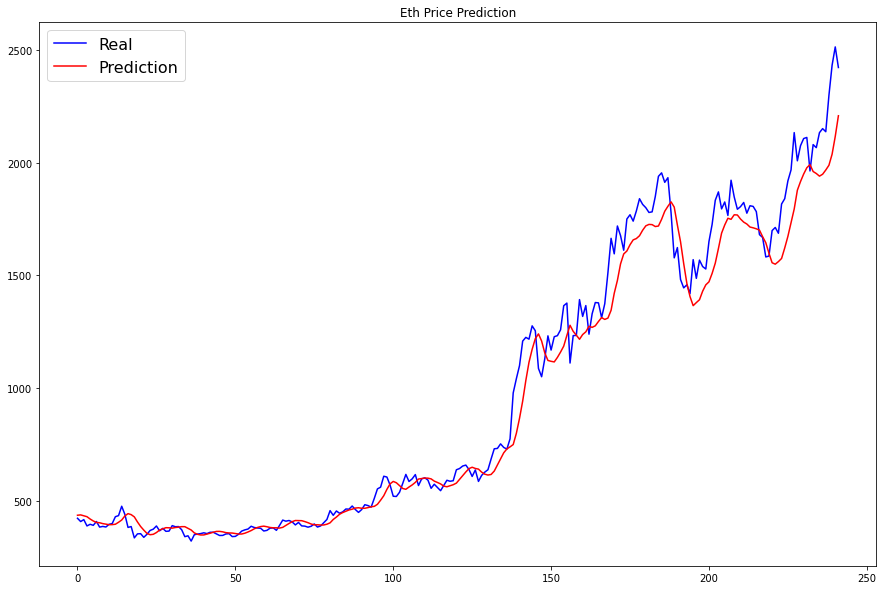

In [22]:
plt.figure(figsize=(15,10))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('Eth Price Prediction')
plt.legend(loc='best', fontsize=16)
plt.show()

I demonstrated how to predict cryptocurrency prices in real time using LSTM neural network. I went through process of getting real-time crptocurrency data, preparing data for training and testing, predicting the prices using LSTM neural network and visualizing the prediction results. Feel free to play with the hyper-parameters or try out different neural network architectures for better results. Using this model itself on cryptocurrency would allow people to make a lot of profits by letting them buying and selling cryptocurrencies at predicted times.